# Übung 1 (Bayes'sches Filtern)

Die Übungsaufgaben werden als Jupyter Notebooks bereitgestellt. Ein solches Notebook besteht aus Zellen, in die Sie direkt R-Code schreiben können. Durch Klicken auf "Run" oben oder Strg+Enter wird die Zelle direkt ausgeführt und das Ergebnis wird angezeigt. Probieren Sie es in der folgenden Zelle direkt einmal aus.

In [15]:
3 + 4

[1] 7

Im Vorlesungsskript wird in Kapitel 4.1 Bayessches Filtern anhand eines Ballistikbeispiels eingeführt.
Hilfreiche Literatur zum Partikel-Filter: “Simo Särkkä: Bayesian Filtering and Smoothing”
(Kapitel 1, 4, 7, 8, 12), “Kevin Murphy: Machine Learning” (Kapitel 17 und 23).

In dieser Übung soll das Systemmodell des Ballistik-Beispiels (Kapitel 4.1 im Skript) implementiert werden. Später werden wir dies als Grundlage nehmen, um einen Partikelfilter für dieses Beispiel zu implementieren. 


Im Ballistik-Beispiel setzt sich der Zustand des Projektils zu einem bestimmten Zeitpunkt aus der X- und Y-Position sowie der komponentenweisen Geschwindigkeit in X- und Y-Richtung zusammen. 

1.  Erstellen Sie eine Funktion `init(angle, v0, locationX)` zum Erzeugen eines Initialzustandes. Dabei soll der Abschusswinkel in Grad, die Initalgeschwindigkeit und die Abschussposition (X-Koordinate, die Y-Koordinate ist immer 0, da das Projektil am Boden abgeschossen wird) übergeben werden. 

In [1]:
# model preferences
time <- 100    # time [s]
tstep <- 10    # steps / sec [1/s]
times <- time*tstep

# physical constants
g    <- -9.81   # gravitational accelaration [m/(s^2)]
sd.v <- 10      # accuracy of liftoff speed [m/s]
sd.a <- 1       # accuracy of elevation angle in [deg]
turb.x <- 10       # acceleration by turbulences [m/(s^2)]
turb.y <- 10       # acceleration by turbulences [m/(s^2)]
cw   <- 0.0001 # aerobraking factor
sd.o <- 10000     # observation accuracy [m]

# game preferences
xmax <- 21000
epsilon <- 300

# plot preferences
ymin <- -100

deg2rad <- function(x) x / 180 * pi

init <- function(ang = 45, v0 = 500, location = 0) {
    v <- v0 + rnorm(1, sd=sd.v)
    a <- deg2rad(rnorm(1, mean=ang, sd=sd.a))
    c(location, 0, v * cos(a), v * sin(a))
}

2. Erstellen Sie eine Funktion `trans(x)`, die für einen Zustand `x` einen Nachfolge-Zustand berechnet. Im Skript (Kapitel 4.1) sind die Gleichungen für die Berechnung des Nachfolgezustands angegeben. 

In [2]:
trans <- function(s) {
    dt <- 1/tstep
    eps.x <- rnorm(1, mean=0, sd=turb.x)
    eps.y <- rnorm(1, mean=0, sd=turb.y)
    acc.x <- -sign(s[3]) * cw * s[3]^2 + eps.x
    acc.y <- g - sign(s[4]) * cw * s[4]^2 + eps.y
    s.x <- s[1] + s[3] * dt + 0.5 * acc.x * dt * dt
    s.y <- s[2] + s[4] * dt + 0.5 * acc.y * dt * dt
    v.x <- s[3] + acc.x * dt
    v.y <- s[4] + acc.y * dt
    c(s.x, s.y, v.x, v.y)
}

3. Erstellen Sie eine Funktion `shoot(angle, v0, locationX)`, die die komplette Flugbahn des Projektils simuliert und zurückgibt (z.B. als Matrix, wobei die Zeilen die einzelnen Zeitpunkte und die Spalten die Komponenten des Zustands (x, y, vx, vy) repräsentieren.

In [3]:
shoot <- function(angle, velocity, location) {
    target <- array(0, dim=c(times,4))
    target[1,] <- init(angle, velocity, location)
    for (t in 2:times) {
        target[t,] <- trans(target[t-1,])
        if (target[t,2] < 0) {
            target <- target[1:(t-1),]
            break
        }
    }
    
    target
}

4. Implementieren Sie eine Funktion, die eine übergebene Flugbahn plottet. Das Bild kann beispielsweise so aussehen: 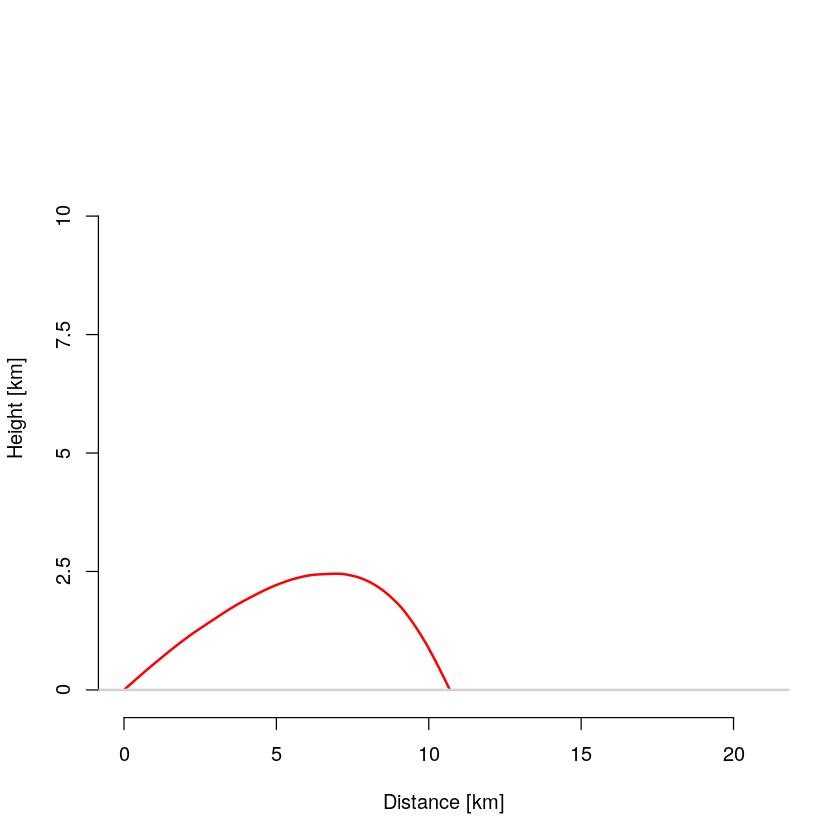

In [4]:
plotshot <- function(target=array(0, dim=c(1,4)), playerLocations=NULL, title="Target", new.plot=TRUE) {
    if (new.plot) {
        plot(NA, ylim=c(ymin,12000), xlim=c(0, xmax), ylab="Height [km]", xlab="Distance [km]", axes=FALSE)
    }
    lines(target[,1], target[,2], col="red", lwd=2)
    axis(2, labels=c("0","2.5","5","7.5","10"), at=c(0,2500,5000,7500,10000))
    axis(1, labels=c("0","5","10","15","20"), at=c(0,5000,10000,15000,20000))
    
    # plot the y=0 line which represents the "ground"
    abline(h=0, col="lightgray", lwd=2)
    
    # tanks
    for (player in seq_along(playerLocations)) {
        points(playerLocations[player], 0, pch=12, cex=1.4, col="brown")
        text(playerLocations[player] + 200, 100, paste0("Player ", player), adj=c(0,0))
    }

    invisible(NULL)
}

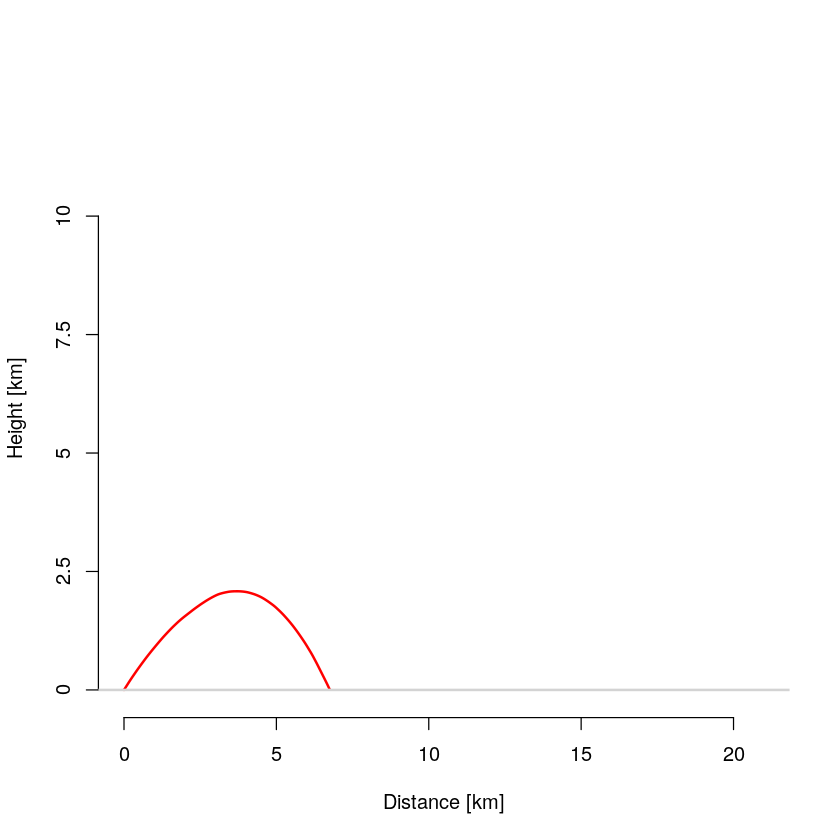

In [9]:
plotshot(shoot(45,300,0))

5. (Zusatz). Die Computerspiele Tank Wars (1986) und Worms (1994) sind populäre Vertreter der sog. Artillery-Computerspiele. Spielinhalt ist, dass mehrere zufällig auf einer Karte platzierte Spieler rundenweise mittels Eingabe von Winkel und Startgeschwindigkeit versuchen, sich gegenseitig als erste zu treffen. Implementieren Sie eine vereinfachte Variante dieses Spielprinzips in R und nutzen Sie dazu die Funktionen aus der vorangegangenen Aufgaben. Nach Eingabe der Spielerzahl sollen diese zufällig auf der X-Achse verteilt werden. Anschließend werden Winkel und Startgeschwindigkeit rundenweise abgefragt, die Trajektorie simuliert und geplottet. Im Falle eines Aufpralls im Radius von 300m wird ein Treffer gemeldet und das Spiel beendet. Erweitern Sie dazu auch die Plotfunktion um die Darstellung der Spielerposition.

In [11]:
main1 <- function(){
  #sample a trajectory and plot
  s <- shoot(30,500,0)
  plotshot(s)
}

game <- function(){
    players <- as.numeric(readline("How many Players? "))
    playerLocations <- sample(1:xmax, players)
    for (player in 1:players)
        cat(paste0("Player ", player, " is located at ",playerLocations[player],"\n\n"))
    plotshot(playerLocations=playerLocations)
    
    player <- 1
    while(TRUE) {
        cat(paste0("# Player ", player, ", it's your turn!\n"))

        ang <- as.numeric(readline("Angle? "))
        if (is.na(ang))
            return(invisible(NULL))
        vel <- as.numeric(readline("Velocity? "))
        if (is.na(vel))
            return(invisible(NULL))


        impact <-shoot(ang, vel, playerLocations[player])
        plotshot(impact, playerLocations)
        impact <- impact[nrow(impact), 1]
        cat(paste0("Impact at location ", impact, ".\n"))
        for (hit in 1:players)
            if (abs(impact - playerLocations[hit]) <= epsilon) {
                cat(paste0("Player ", player, " hit Player ",hit," at location ",playerLocations[hit],"!\n"))
                cat("# GAME OVER\n")
                return(invisible(NULL))
            }

        player <- player %% players + 1
        cat("\n")    
    }
    # never reached
}



In [ ]:
game()